<a href="https://colab.research.google.com/github/SballarinAndre/Disciplina-Nexus/blob/main/analisesCABra_new_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import gc
import cftime
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr


In [2]:
# Finding CABRa attributes csv files
pathFiles = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/')
cabraAttributesFiles = pathFiles.rglob('*.csv')


In [ ]:
# Reading files
dfs = []
for file in cabraAttributesFiles:
    print(file)
    df = pd.read_csv(file, engine='python', delimiter=',')
    dfs.append(df)

In [4]:
# Merging DataFrames
dfMerged = reduce(lambda  left,right: pd.merge(left, right, on=['CABra ID', 'ANA ID'], how='outer'), dfs)

In [5]:
dfMerged.columns

Index(['CABra ID', 'ANA ID', 'longitude_centroid', 'latitude_centroid',
       'dist_coast', 'clim_p', 'clim_tmin', 'clim_tmax', 'clim_rh',
       'clim_wind', 'clim_srad', 'clim_et', 'clim_pet', 'aridity_index',
       'p_seasonality', 'clim_quality', 'aquif_name', 'aquif_type',
       'catch_wtd', 'catch_hand', 'hand_class', 'dist_urban', 'cover_urban_x',
       'cover_crops_x', 'res_number', 'res_area', 'res_volume',
       'res_regulation', 'water_demand', 'hdisturb_index', 'cover_main',
       'cover_bare', 'cover_forest', 'cover_crops_y', 'cover_grass',
       'cover_moss', 'cover_shrub', 'cover_urban_y', 'cover_snow',
       'cover_waterp', 'cover_waters', 'ndvi_djf', 'ndvi_mam', 'ndvi_jja',
       'ndvi_son', 'longitude', 'latitude', 'gauge_hreg', 'gauge_biome',
       'gauge_state', 'missing_data', 'series_length', 'quality_index',
       'catch_lith', 'sub_porosity', 'sub_permeability', 'sub_hconduc',
       'soil_type', 'soil_textclass', 'soil_sand', 'soil_silt', 'soil_clay'

In [6]:
#Values for annual time-scale
dfMerged['clim_p_annual'] = dfMerged['clim_p']*365.26667
dfMerged['clim_pet_annual'] = dfMerged['clim_pet']*365.26667

In [7]:
# Calculating ECI (Liu et al. (2020))
# Calculating the ratio Effective Area / Topographic Area (Liu et al. (2020))
dfMerged['ECI'] = np.log10(dfMerged['q_mean']/(dfMerged['clim_p']-dfMerged['clim_et']))
dfMerged['Aeff/Atopo'] = dfMerged['q_mean']/(dfMerged['clim_p']-dfMerged['clim_et'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# Creating new column called 'substantial' and grouping into 3 groups
# The ratio is according to Liu et al. (2020)
max_ratio = 2
min_ratio = 0.5

dfMerged.loc[dfMerged['Aeff/Atopo']>=max_ratio, 'substantial'] = 'Gaining'
dfMerged.loc[(dfMerged['Aeff/Atopo']<max_ratio)&
              (dfMerged['Aeff/Atopo']>1), 'substantial'] = 'Small gain'
dfMerged.loc[(dfMerged['Aeff/Atopo']>min_ratio)&
              (dfMerged['Aeff/Atopo']<=1), 'substantial'] = 'Small loss'
dfMerged.loc[dfMerged['Aeff/Atopo']<=min_ratio, 'substantial'] = 'Losing'



In [9]:
#Correcting values of Q according to Aeff/Atopo
dfMerged['q_quickflow_annual_corrected'] = dfMerged['q_quickflow_annual']/dfMerged['Aeff/Atopo']
dfMerged['q_baseflow_annual_corrected'] = dfMerged['q_baseflow_annual']/dfMerged['Aeff/Atopo']
dfMerged['q_annual_corrected'] = dfMerged['q_annual']/dfMerged['Aeff/Atopo']

In [15]:
#Filtering catchments - Excluding catchments with runoff coeficient > 1 and/or null values of ECI
dfFinal = dfMerged[dfMerged['runoff_coef'] < 1]
dfFinal = dfFinal[dfFinal['ECI'].notnull()]

In [16]:
# The column 'catch_area' is problematic, because it was a object type.
# Changed to 'int'
dfFinal['catch_area'] = dfFinal['catch_area'].str.replace('.','')
dfFinal['catch_area'] = dfFinal['catch_area'].astype('int64')
dfFinal['catch_area'] = dfFinal['catch_area']/1000

In [17]:
#Selecting catchments using area

# dfFinal = dfFinal[(dfFinal['catch_area']< 25000)]
dfFinal[['Aeff/Atopo','catch_area']].describe()

,Aeff/Atopo,catch_area
count,731.000000,7.310000e+02
mean,1.023410,4.505083e+04
std,0.398882,2.392210e+05
min,0.102564,3.163000e+00
25%,0.812509,8.508350e+02
50%,1.005525,2.906530e+03
75%,1.194200,1.283298e+04
max,3.866667,4.807564e+06


In [ ]:
#Defining BIAS of estimated Qb, Qd, Q and W
D = 0.38
def funcD_teste(x,a,b):
    return (np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b

def funcB_teste(x,c,d):
    return (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d
def funcR_teste(x,a,b,c,d):
    return ((np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b + (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d)


In [ ]:

par_aFinal= 1.08816485819687
par_bFinal= 1.23095186755981
par_cFinal= 1.19865250119228
par_dFinal= 0.735063074344181

x = dfFinal['aridity_index']
p = dfFinal['clim_p_annual']
qB = dfFinal['q_baseflow_annual']
qD = dfFinal['q_quickflow_annual']
qQ  = dfFinal['q_annual']
w  = dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual']

yD_est = funcD_teste(x,par_aFinal, par_bFinal)
yB_est = funcB_teste(x,par_cFinal, par_dFinal)
yQ_est = funcR_teste(x,par_aFinal, par_bFinal, par_cFinal, par_dFinal)
qB_est = yB_est*p
qD_est = yD_est*p
qQ_est = yQ_est*p
w_est  = p - qD_est

# dfFinal['q_baseflow_bias'] = ((qB_est - qB)/qB)*100
# dfFinal['q_quickflow_bias'] = ((qD_est - qD)/qD)*100
# dfFinal['q_bias'] = ((qQ_est - qQ)/qQ)*100
# dfFinal['w_bias'] = ((w_est - w)/w)*100
dfFinal['q_baseflow_annual_est'] = qB_est
dfFinal['q_quickflow_annual_est'] = qD_est
dfFinal['q_annual_est'] = qQ_est
dfFinal['w_annual_est'] = w_est

par_aFinal_corr= 0.72099025727739
par_bFinal_corr= 1.30100172735143
par_cFinal_corr= 0.752050524211796
par_dFinal_corr= 0.810305052137073

x = dfFinal['aridity_index']
p = dfFinal['clim_p_annual']
qB_cor = dfFinal['q_baseflow_annual_corrected']
qD_cor = dfFinal['q_quickflow_annual_corrected']
qQ_cor = dfFinal['q_annual_corrected']
w_cor  = dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual_corrected']

yD_est_cor = funcD_teste(x,par_aFinal_corr, par_bFinal_corr)
yB_est_cor = funcB_teste(x,par_cFinal_corr, par_dFinal_corr)
yQ_est_cor = funcR_teste(x,par_aFinal_corr, par_bFinal_corr, par_cFinal_corr, par_dFinal_corr)
qB_est_cor = yB_est_cor*p
qD_est_cor = yD_est_cor*p
qQ_est_cor = yQ_est_cor*p
w_est_cor  = p - qD_est_cor

# dfFinal['q_baseflow_bias_corrected'] = ((qB_est_cor - qB_cor)/qB_cor)*100
# dfFinal['q_quickflow_bias_corrected'] = ((qD_est_cor - qD_cor)/qD_cor)*100
# dfFinal['q_bias_corrected'] = ((qQ_est_cor - qQ_cor)/qQ_cor)*100
# dfFinal['w_bias_corrected'] = ((w_est_cor - w_cor)/w_cor)*100
dfFinal['q_baseflow_annual_est_cor'] = qB_est_cor
dfFinal['q_quickflow_annual_est_cor'] = qD_est_cor
dfFinal['q_annual_est_cor'] = qQ_est_cor
dfFinal['w_annual_est_cor'] = w_est_cor




rmse_corr = mean_squared_error(qB_est_cor,qB_est, squared=False)
rmse = mean_squared_error(qB_est,qB, squared=False)


dfFinal['bias_qb'] = dfFinal['q_baseflow_annual']/dfFinal['clim_p_annual'] - dfFinal['q_baseflow_annual_est']/dfFinal['clim_p_annual']
dfFinal['bias_qb_corrected'] = dfFinal['q_baseflow_annual_corrected']/dfFinal['clim_p_annual'] - dfFinal['q_baseflow_annual_est_cor']/dfFinal['clim_p_annual']
dfFinal['bias_q'] = dfFinal['q_annual']/dfFinal['clim_p_annual'] - dfFinal['q_annual_est']/dfFinal['clim_p_annual']
dfFinal['bias_q_corrected'] = dfFinal['q_annual_corrected']/dfFinal['clim_p_annual'] - dfFinal['q_annual_est_cor']/dfFinal['clim_p_annual']
dfFinal['bias_qd'] = dfFinal['q_quickflow_annual']/dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual_est']/dfFinal['clim_p_annual']
dfFinal['bias_qd_corrected'] = dfFinal['q_quickflow_annual_corrected']/dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual_est_cor']/dfFinal['clim_p_annual']


In [ ]:
dfFinal['Aeff/Atopo'].describe()

count    357.000000
mean       1.041065
std        0.561062
min        0.102564
25%        0.619048
50%        0.800000
75%        1.384858
max        3.866667
Name: Aeff/Atopo, dtype: float64

In [ ]:
#Evaluation of correlation between variables and bias_Qb and bias_Qb_est...

#Pre-selection of variables
variables = ['dist_coast','aridity_index','p_seasonality',  'aquif_name', 'aquif_type',
             'catch_wtd', 'catch_hand', 'hand_class','res_area',  'hdisturb_index',
             'q_elasticity', 'baseflow_index',  'gauge_hreg', 'gauge_biome', 'gauge_state',
             'catch_lith', 'sub_porosity', 'sub_permeability', 'sub_hconduc', 'soil_type',
             'soil_textclass','elev_mean', 'catch_slope', 'catch_order', 
             'latitude_centroid', 'longitude_centroid', 'cover_forest','cover_urban_x','cover_crops_x']


# Removing non-numerical variables
numberVariables = []
for v, i in zip(variables, dfFinal[variables].dtypes):
    if ('float' in str(i)) or ('int' in str(i)):
        numberVariables.append(v)
    else:
        pass

In [ ]:
numberVariables

['dist_coast',
 'aridity_index',
 'p_seasonality',
 'catch_wtd',
 'catch_hand',
 'res_area',
 'hdisturb_index',
 'q_elasticity',
 'baseflow_index',
 'sub_porosity',
 'sub_permeability',
 'sub_hconduc',
 'elev_mean',
 'catch_slope',
 'catch_order',
 'latitude_centroid',
 'longitude_centroid',
 'cover_forest',
 'cover_urban_x',
 'cover_crops_x']

Text(0.5, 1.0, 'Spearman')

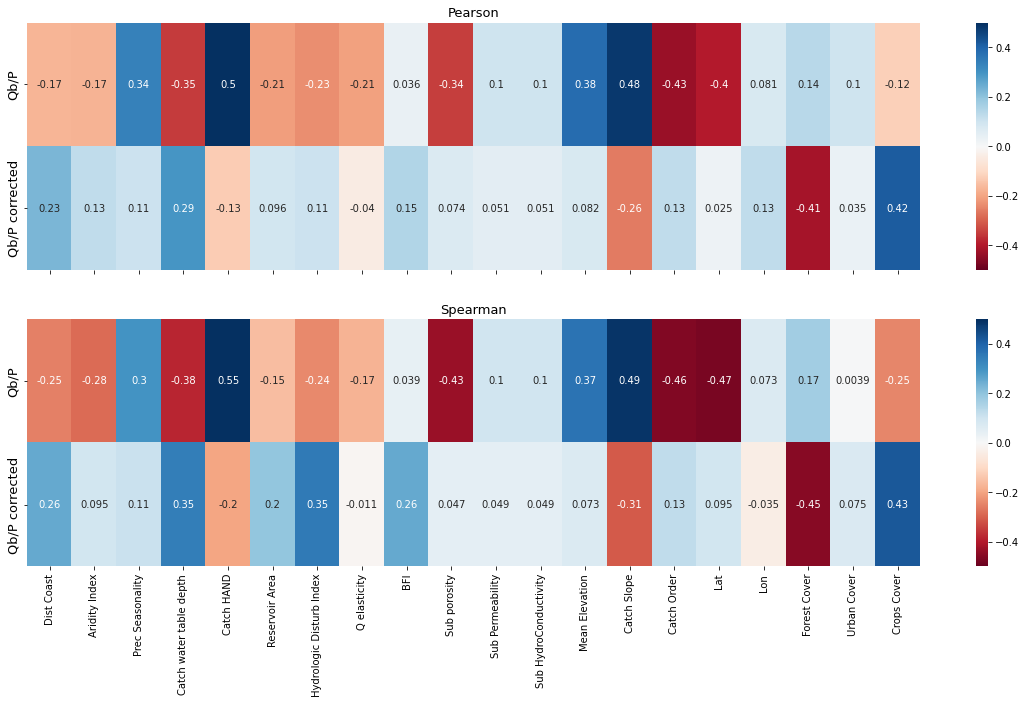

In [ ]:
#Defining correlation
labelVariables = ['Dist Coast','Aridity Index','Prec Seasonality','Catch water table depth','Catch HAND',
                  'Reservoir Area','Hydrologic Disturb Index','Q elasticity','BFI','Sub porosity','Sub Permeability',
                  'Sub HydroConductivity','Mean Elevation','Catch Slope','Catch Order','Lat','Lon','Forest Cover',
                  'Urban Cover','Crops Cover']

qVar = 'bias_qb'
qVarCorrected = 'bias_qb_corrected'
corrQb_pearson = []
corrQb_corrected_pearson = []
corrQb_spearman = []
corrQb_corrected_spearman = []

for var in numberVariables:

  spQb = spearmanr(dfFinal[qVar],dfFinal[var])
  spQb_corr = spearmanr(dfFinal[qVarCorrected],dfFinal[var])
  corrQb_spearman.append(spQb[0])
  corrQb_corrected_spearman.append(spQb_corr[0])
  peQb = pearsonr(dfFinal[qVar],dfFinal[var])
  peQb_corr = pearsonr(dfFinal[qVarCorrected],dfFinal[var])
  corrQb_pearson.append(peQb[0])
  corrQb_corrected_pearson.append(peQb_corr[0])



dfCorrelation_spearman = pd.DataFrame({'Q': corrQb_spearman,'Q_corrected':corrQb_corrected_spearman})
dfCorrelation_pearson = pd.DataFrame({'Q': corrQb_pearson,'Q_corrected':corrQb_corrected_pearson})



fig,ax = plt.subplots(nrows = 2, figsize = (20,10), sharex = True)

pearson_corr = sns.heatmap(dfCorrelation_pearson.T, annot=True, cmap = 'RdBu',
                           xticklabels=labelVariables, fmt='.2', ax = ax[0], vmin = -0.5, vmax = 0.5)
spearman_corr = sns.heatmap(dfCorrelation_spearman.T, annot=True, cmap = 'RdBu',
                           xticklabels=labelVariables, fmt='.2', ax = ax[1], vmin = -0.5, vmax = 0.5)
ax[0].set_yticklabels(['Qb/P','Qb/P corrected'], fontsize = 13)
ax[1].set_yticklabels(['Qb/P','Qb/P corrected'], fontsize = 13)
ax[0].set_title('Pearson', fontsize = 13)
ax[1].set_title('Spearman', fontsize = 13)
# ax[0].set_xticklabels(labelVariables, fontsize = 13)
# ax[1].set_xticklabels(labelVariables, fontsize = 13)
# fig.savefig('/content/drive/MyDrive/Colab Notebooks/CABra_Figures/Q_p_correlation_no_abs.jpeg', dpi=500)

